# My Internet Speeds for the Last Year

Please see [my accompanying blog post](/2017/10/my-internet-speeds-for-the-last-year/). 

This notebook and the data files referenced below are available for download:

- [my-internet-speeds-for-the-last-year.ipynb](/uploads/2017/10/my-internet-speeds-for-the-last-year.ipynb)
- [speed.csv](/uploads/2017/10/hass_speeds.csv)
- [hass_speeds.csv](/uploads/2017/10/hass_speeds.csv)

## speedtest-cli data

Data gathering with [speed](https://github.com/n8henrie/speed), a simple wrapper around speedtest-cli

In [1]:
import pandas as pd

stcli_df = pd.read_csv("speed.csv", parse_dates=[0], index_col=0)
stcli_df.head()

,Average Download,Trimmed Average Download,Average Upload,Trimmed Average Upload,Runs,Dropped Outliers
Date,,,,,,
2016-06-01 22:16:00,16.81,16.79,1.85,1.86,5,True
2016-06-02 15:51:00,6.26,6.18,1.10,1.15,5,True
2016-06-02 16:04:00,6.14,5.90,1.11,1.11,5,True
2016-06-02 17:03:00,15.98,16.04,1.69,1.71,5,True
2016-06-02 18:03:00,15.91,15.93,1.69,1.68,5,True


**Note:** the `Trimmed Average` columns drop the fasted and slowest speeds for the 5-run test and average the remaining three.

In [2]:
# Make new column with rolling mean for 1 day periods
stcli_daily_mean = stcli_df[['Trimmed Average Download']].resample('1D').mean()
stcli_rolling_mean = stcli_daily_mean.rolling(7, min_periods=7).mean().dropna()
stcli_rolling_mean.head()

,Trimmed Average Download
Date,
2016-06-07,13.386530
2016-06-08,12.375696
2016-06-09,13.140389
2016-06-10,19.547079
2016-06-11,30.118937


<IPython.core.display.Javascript object>


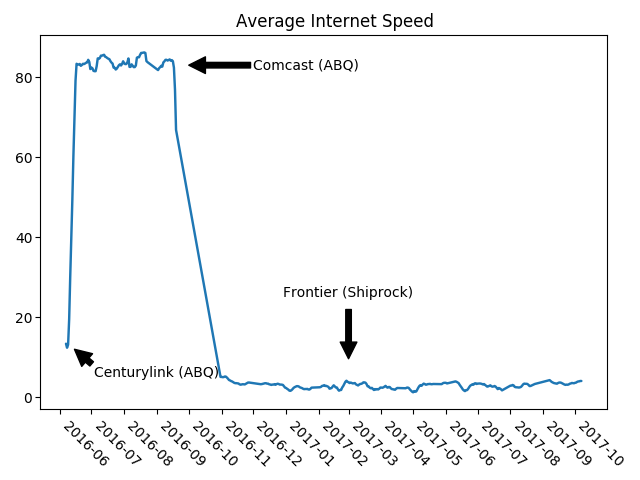

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib notebook

fig, ax = plt.subplots()

plt.xticks(rotation=-45, horizontalalignment='left')
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))

ax.set_title("Average Internet Speed")

ax.annotate("Centurylink (ABQ)", xy=("2016-06-15", 12), xytext=("2016-09", 5), ha="center",
            arrowprops=dict(facecolor='black'),
            )
ax.annotate("Comcast (ABQ)", xy=("2016-10", 83), xytext=("2016-12", 83), va="center",
            arrowprops=dict(facecolor='black'),
            )
ax.annotate("Frontier (Shiprock)", xy=("2017-03", 8), xytext=("2017-03", 25), ha="center",
            arrowprops=dict(facecolor='black', shrink=0.10),
            )

with plt.style.context("seaborn"):
    plt.plot(stcli_rolling_mean)
    plt.tight_layout()

## Home Assistant Data

`hass_speeds.csv` comes from [Home Assistant](https://home-assistant.io)'s [Fast.com sensor](https://home-assistant.io/components/sensor.fastdotcom/). "Unknown" speeds usually mean that either the internet was out, (or possibly that I was working on the modem, which was usually because the internet was out), so I am replacing these values with `0`.

In [4]:
hass_df = pd.read_csv(
    "hass_speeds.csv",
    parse_dates=[1],
    index_col=1,
    header=0,
    names=["Speed", "Date"],
    converters={'Speed': lambda val: 0. if val == 'unknown' else float(val)},
)
hass_df.head()

,Speed
Date,
2016-12-16 19:33:22.148945,0.0
2016-12-16 19:48:11.516207,0.0
2016-12-16 20:00:31.001134,6.0
2016-12-16 20:30:31.275227,5.7
2016-12-16 21:00:30.894412,2.7


In [5]:
hass_daily_mean = hass_df[hass_df["Speed"] != 0.0].resample("1D").mean()
hass_rolling_mean = hass_daily_mean.rolling(7, min_periods=7).mean().dropna()

In [6]:
from bokeh.plotting import figure, output_notebook, show

output_notebook()

p = figure(
    title="Internet speed with Frontier (excluding dropouts)",
    y_axis_label='Download Speed (Mbps)',
    x_axis_type='datetime',
    x_range=(hass_rolling_mean.index.min(),hass_rolling_mean.index.max()),
    y_range=(hass_rolling_mean['Speed'].min(),hass_rolling_mean['Speed'].max()),
)
p.title.text_font_size = '16pt'
p.line(
    x=hass_rolling_mean.index,
    y=hass_rolling_mean['Speed'],
    legend="Fast.com",
    line_width=2,
    color="DodgerBlue",
)
p.line(
    x=stcli_rolling_mean.index,
    y=stcli_rolling_mean['Trimmed Average Download'],
    legend="speedtest-cli",
    line_width=2,
    color="LightCoral",
)

show(p)

Loading BokehJS ...

In [7]:
# Count of dropouts per day, renaming the column appropriately
dropouts = hass_df[hass_df['Speed'] == 0.].resample('1D').count()
dropouts.columns = ["Count"]

<IPython.core.display.Javascript object>


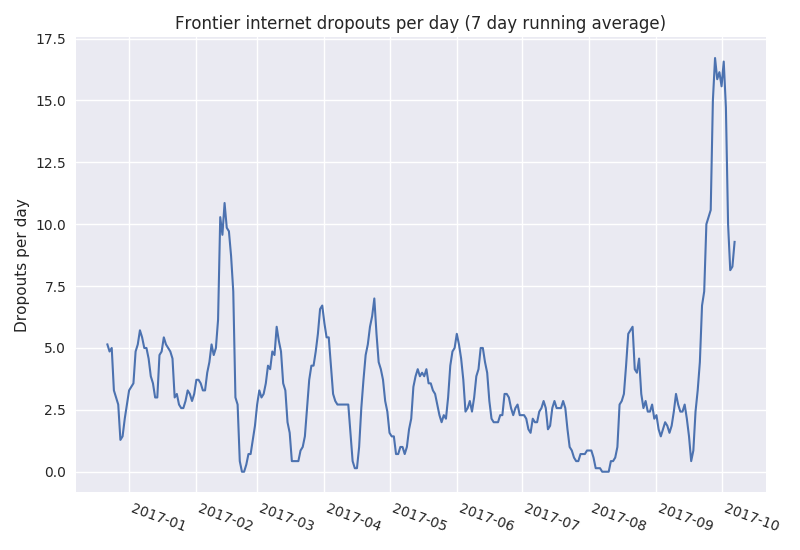

In [8]:
# 7 day rolling average for number of dropouts per day
rolling_dropouts = dropouts.rolling(7).mean()

with plt.style.context("seaborn"):
    fig, ax = plt.subplots()

plt.xticks(rotation=-20, horizontalalignment='left')
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))

ax.set_ylabel("Dropouts per day")
plt.title("Frontier internet dropouts per day (7 day running average)")

plt.plot(rolling_dropouts.index, rolling_dropouts)
plt.tight_layout()

<IPython.core.display.Javascript object>


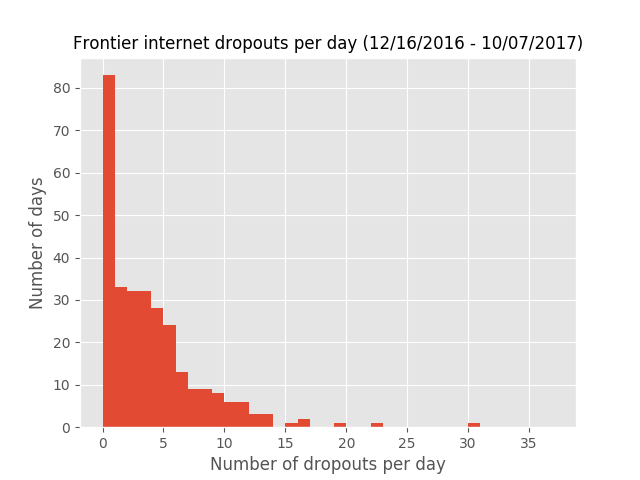

In [9]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots()

plt.hist(dropouts['Count'], bins=range(0, dropouts['Count'].max()))

datefmt="%m/%d/%Y"
plt.ylabel("Number of days")
plt.xlabel("Number of dropouts per day")
plt.title(f"Frontier internet dropouts per day ({dropouts.index[0]:{datefmt}} - {dropouts.index[-1]:{datefmt}})")
plt.show()

In [10]:
overall_average = hass_df[(hass_df['Speed'] != 0.0) & (hass_df['Speed'].notnull())].mean()[0]
print(f"Average internet speed for Frontier (excluding dropouts): {overall_average:.2} Mbps")

Average internet speed for Frontier (excluding dropouts): 4.3 Mbps
